<div class="alert alert-block alert-success"> Hello:) Now all is fine, thank you! Good luck with next steps </div> 

<div class="alert alert-block alert-info"> Hello, Anna! Your text in plan is good. But design is not good. You should use abilities of Mardown cells to design the plan structure better. You can use, for instance, titles, subtitles, bold text, vertical list of bullets (like you did in Presentation part) and so on. So, please, make your plan looks better cuz now it's difficult to read it. Also, please, add the short project description. It's a good practice for any project you will work on. You can even just copy-paste it from notion:) </div> 

# **Identifying Ineffective Operators.** 

## Project description.

In this project I will look at the data from the virtual telephony company and work on finding the least profitable operators with the help of that data. I will also try developping a new function that will give supervisors information on the least effective operators. According to the instructions from the company,  an operator is considered ineffective if the following is true.
### First: many missed calls.
If the operator has a large number of missed incoming calls (internal and external) it is considered a bad sign.

### Second: long waiting time.
If there is a long waiting time for incoming calls, it is also a problem.

### Third: too few outgoing calls.
It is concerning if an operator is supposed to make outgoing calls but there is a relatively small number of them recorded.

In [2]:
import pandas as pd
import numpy as np
import math as mth
from functools import reduce
from scipy import stats as st
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.stats import weightstats as stests

In [3]:
telecom_dataset = pd.read_csv('telecom_dataset_us.csv')
telecom_dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [4]:
telecom_clients = pd.read_csv('telecom_clients_us.csv')
telecom_clients

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [5]:
telecom_dataset.isna().any()

user_id                False
date                   False
direction              False
internal                True
operator_id             True
is_missed_call         False
calls_count            False
call_duration          False
total_call_duration    False
dtype: bool

In [6]:
telecom_dataset_missing = telecom_dataset.isna()
telecom_dataset_missing

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
53897,False,False,False,False,False,False,False,False,False
53898,False,False,False,False,False,False,False,False,False
53899,False,False,False,False,False,False,False,False,False
53900,False,False,False,False,False,False,False,False,False


In [7]:
telecom_clients.isna().any()

user_id        False
tariff_plan    False
date_start     False
dtype: bool

In [8]:
telecom_dataset_missing.sum() 

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [9]:
telecom_dataset.info()
#As we can see, the percentage of missing values is like this: 117 out of 53902 for internal and 8172 out of 53902 for operator_id
#Now, 8172 is around 15%. It's quite a lot. However, this column will be very important for the analysis, so I would risk removing them.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [10]:
telecom_dataset.drop(telecom_dataset[telecom_dataset['operator_id'] == 'NaN'].index, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [11]:
telecom_dataset_missing.sum() 

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [12]:
#telecom_dataset = telecom_dataset.drop_duplicates()
#telecom_clients = telecom_clients.drop_duplicates() #dropping duplicates


First I will research telecommunication, just in case there are any typical issues that I should look out for. Now to work.

## Preprocessing.
###   First look.
I will open the data and looking at it (shape, describe, info, value_counts etc.).
###   Checking missing values. 
I will take a look at the percentage of missing values and remove them in case the percentage is low enough.  If there are too many missing values to remove I will replace them with median for numerical colunms (I consider it most effective method since it doesn't get skewed as easily as mean) and something like 'none' for others.  
### Checking the datatypes.
Looking at the datatypes for all the columns, changing them if necessary. 
### Outliers
I will remove the outliers ( I want to do it in advance because I intend to split the data several times later).

I decided to remove outliers based on IQR, but I believe that z-score would have yielded the same results.

In [13]:

Q1 = telecom_dataset.quantile(0.25)
Q3 = telecom_dataset.quantile(0.75)
IQR = Q3 - Q1

telecom_dataset = telecom_dataset[~((telecom_dataset < (Q1 - 1.5 * IQR)) |(telecom_dataset > (Q3 + 1.5 * IQR))).any(axis=1)]

telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43214 entries, 0 to 53901
Data columns (total 9 columns):
user_id                43214 non-null int64
date                   43214 non-null object
direction              43214 non-null object
internal               43098 non-null object
operator_id            35665 non-null float64
is_missed_call         43214 non-null bool
calls_count            43214 non-null int64
call_duration          43214 non-null int64
total_call_duration    43214 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


In [14]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format="%Y-%m-%d %H:%M")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Exploratory data analysis. 

### Splitting the dataframe.
First I will divide dataset by missed calls (missed or not) and look at them separately.
### Looking at missing calls percentage for each operator.
I will look at the both df's and see which operators have the worst missed/not missed calls ratio. I want to use this identify the least profitable operator. I will group calls by operator in both dfs.
### Visualization.
I will plot average waiting time by operator, that is also to look for the least profitable ones. Waiting time is a new column, total call duration minus call duration. 
### Looking at missed calls by month. 
Then I will look at the original df and plot missed calls by date, this may help me determine the most and least profitable months, this is useful information.
### Looking at internal/external calls percentage for each operator.
I will also group calls both missed and not missed dfs by internal/external, see the percentage of missed calls for each operator for internal and external calls. 


In [15]:
telecom_dataset['is_missed_call'].value_counts()

False    22520
True     20694
Name: is_missed_call, dtype: int64

In [16]:
telecom_dataset_missed = telecom_dataset.query('is_missed_call == True').reset_index()

In [17]:
telecom_dataset_taken = telecom_dataset.query('is_missed_call == False').reset_index()

In [18]:
telecom_dataset['operator_id'].value_counts()

887276.0    271
889410.0    259
901884.0    255
900892.0    250
899250.0    226
           ... 
962904.0      1
923744.0      1
956664.0      1
891192.0      1
937710.0      1
Name: operator_id, Length: 1081, dtype: int64

In [19]:
all = telecom_dataset.groupby('operator_id')['is_missed_call'].count()
all

operator_id
879896.0    111
879898.0    138
880020.0     22
880022.0     74
880026.0    130
           ... 
972410.0      2
972412.0      3
972460.0      9
973120.0      2
973286.0      1
Name: is_missed_call, Length: 1081, dtype: int64

In [20]:
missed = telecom_dataset_missed.groupby('operator_id')['is_missed_call'].count()
missed

operator_id
879896.0    47
879898.0    57
880020.0     7
880022.0    33
880026.0    94
            ..
972408.0     2
972410.0     2
972412.0     2
972460.0     3
973120.0     1
Name: is_missed_call, Length: 864, dtype: int64

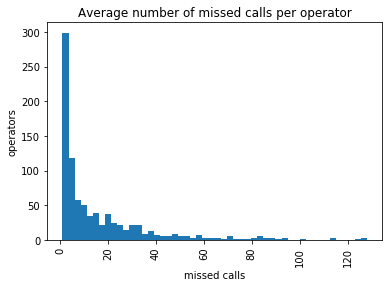

In [116]:
plt.hist(missed, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('missed calls')
plt.ylabel('operators')
plt.title('Average number of missed calls per operator')
plt.show()

We can see that on average the situation with missing calls is not terrible. 

In [21]:
taken = telecom_dataset_taken.groupby('operator_id')['is_missed_call'].count()
taken

operator_id
879896.0    64
879898.0    81
880020.0    15
880022.0    41
880026.0    36
            ..
972408.0     1
972412.0     1
972460.0     6
973120.0     1
973286.0     1
Name: is_missed_call, Length: 1006, dtype: int64

In [ ]:
f = lambda x, y : (x/y)*100

In [ ]:
perc_missed = f(missed, all).sort_values(ascending=False) #Here we can see the percentage of missed calls by operator id.
perc_missed

In [ ]:
perc_missed.value_counts()

In [25]:
perc_taken = f(taken, all).sort_values(ascending=False) #Here we can see the percentage of taken calls by operator id.

In [26]:
perc_taken.value_counts()

100.000000    217
50.000000      60
66.666667      42
60.000000      24
75.000000      22
             ... 
65.333333       1
69.696970       1
60.344828       1
58.571429       1
97.222222       1
Name: is_missed_call, Length: 379, dtype: int64

In [27]:
telecom_dataset['total_call_duration'].value_counts().sort_values(ascending=False)

0       1316
2        844
1        521
4        458
6        379
        ... 
1532       1
1596       1
1629       1
1661       1
1583       1
Name: total_call_duration, Length: 1727, dtype: int64

In [28]:
telecom_dataset['call_duration'].value_counts().sort_values(ascending=False)

0       20389
1         200
7         144
15        126
13        125
        ...  
1246        1
1245        1
1372        1
990         1
1383        1
Name: call_duration, Length: 1424, dtype: int64

In [29]:
telecom_dataset['waiting_time'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
telecom_dataset['waiting_time'].value_counts().sort_values(ascending=False) #We can see there are a few 

0       1351
2       1168
4        819
6        789
9        770
        ... 
915        1
1011       1
1075       1
660        1
847        1
Name: waiting_time, Length: 830, dtype: int64

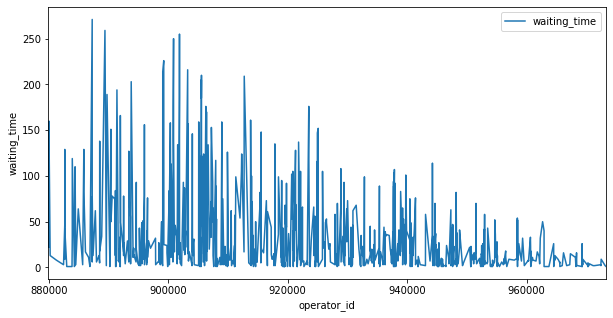

In [108]:
telecom_dataset.groupby('operator_id')['waiting_time'].count().plot(legend=True,figsize=(10,5))
plt.xlabel('operator_id')
plt.ylabel('waiting_time')
plt.show() #plotting waiting_time by operator.

In [114]:
waiting = telecom_dataset.groupby('operator_id')['waiting_time'].count()

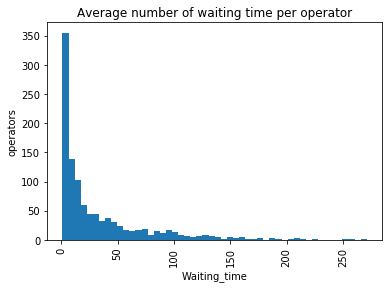

In [115]:
plt.hist(waiting, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('Waiting_time')
plt.ylabel('operators')
plt.title('Average number of waiting time per operator')
plt.show()

The waiting time is usually short.

In [32]:
telecom_dataset['month'] = telecom_dataset['date'].dt.month

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
telecom_dataset['month'].value_counts()

11    18980
10    15225
9      7424
8      1585
Name: month, dtype: int64

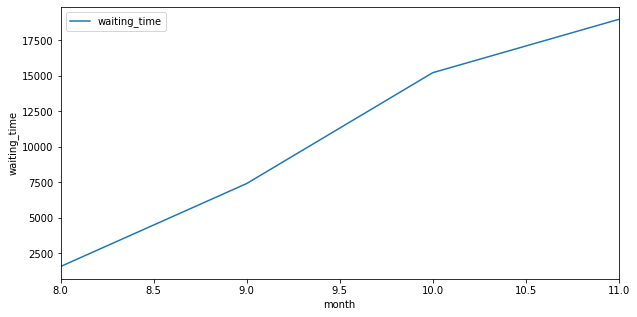

In [107]:
telecom_dataset.groupby('month')['waiting_time'].count().plot(legend=True,figsize=(10,5))
plt.xlabel('month')
plt.ylabel('waiting_time')
plt.show() 
#plotting waiting_time by month. We can clearly see that waiting time significantly increases each month from 8 to 11 

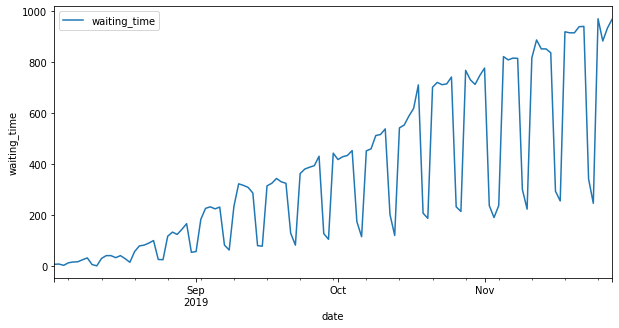

In [106]:
telecom_dataset.groupby('date')['waiting_time'].count().plot(legend=True,figsize=(10,5))
plt.xlabel('date')
plt.ylabel('waiting_time')
plt.show() 

In [36]:
telecom_dataset_missed_internal = telecom_dataset_missed.query('internal == True').reset_index()

In [37]:
telecom_dataset_missed_external = telecom_dataset_missed.query('internal == False').reset_index()

In [38]:
telecom_dataset_taken_internal = telecom_dataset_taken.query('internal == True').reset_index()

In [39]:
telecom_dataset_taken_external = telecom_dataset_taken.query('internal == False').reset_index()

In [40]:
telecom_dataset_all_internal = telecom_dataset.query('internal == True').reset_index()

In [41]:
telecom_dataset_all_external = telecom_dataset.query('internal == False').reset_index()

In [42]:
all_internal = telecom_dataset_all_internal.groupby('operator_id')['internal'].count()
all_internal

operator_id
879896.0    16
879898.0    16
880020.0     3
880022.0     8
880026.0    14
            ..
969386.0     2
970242.0     1
970244.0     1
970254.0     2
972460.0     2
Name: internal, Length: 567, dtype: int64

In [43]:
all_external = telecom_dataset_all_external.groupby('operator_id')['internal'].count()
all_external

operator_id
879896.0     95
879898.0    121
880020.0     19
880022.0     66
880026.0    116
           ... 
972410.0      2
972412.0      3
972460.0      7
973120.0      2
973286.0      1
Name: internal, Length: 1038, dtype: int64

In [44]:
telecom_dataset_missed_internal

,level_0,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,1,1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
1,2,2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
2,10,12,166377,2019-08-06 00:00:00+03:00,out,True,881278.0,True,2,0,5
3,17,25,166377,2019-08-12 00:00:00+03:00,out,True,880028.0,True,1,0,26
4,20,29,166377,2019-08-13 00:00:00+03:00,out,True,880026.0,True,2,0,23
...,...,...,...,...,...,...,...,...,...,...,...
2962,20507,53528,168416,2019-11-19 00:00:00+03:00,out,True,948182.0,True,1,0,0
2963,20541,53614,168466,2019-11-14 00:00:00+03:00,in,True,NaN,True,1,0,0
2964,20568,53661,168481,2019-11-11 00:00:00+03:00,in,True,NaN,True,4,0,25
2965,20663,53836,168601,2019-11-12 00:00:00+03:00,out,True,952914.0,True,1,0,0


In [45]:
missed_internal = telecom_dataset_missed_internal.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
missed_internal

operator_id  internal
891410.0     True        46
891414.0     True        44
905564.0     True        42
905566.0     True        42
906406.0     True        36
                         ..
937710.0     True         1
937736.0     True         1
905308.0     True         1
904344.0     True         1
972460.0     True         1
Name: internal, Length: 457, dtype: int64

In [46]:
missed_external = telecom_dataset_missed_external.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
missed_external

operator_id  internal
901880.0     False       105
901884.0     False        92
893804.0     False        87
890404.0     False        85
880028.0     False        83
                        ... 
940814.0     False         1
940848.0     False         1
941838.0     False         1
906076.0     False         1
973120.0     False         1
Name: internal, Length: 795, dtype: int64

In [47]:
taken_internal = telecom_dataset_taken_internal.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
taken_internal

operator_id  internal
907952.0     True        62
896008.0     True        58
888532.0     True        56
907182.0     True        56
906296.0     True        53
                         ..
929884.0     True         1
929542.0     True         1
929340.0     True         1
928202.0     True         1
934000.0     True         1
Name: internal, Length: 388, dtype: int64

In [48]:
taken_external = telecom_dataset_taken_external.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
taken_external

operator_id  internal
889410.0     False       176
899250.0     False       151
900892.0     False       150
899082.0     False       135
903254.0     False       135
                        ... 
940782.0     False         1
953940.0     False         1
953460.0     False         1
953458.0     False         1
973286.0     False         1
Name: internal, Length: 968, dtype: int64

In [49]:
perc_missed_internal = f(missed_internal, all_internal).value_counts().sort_values(ascending=False)
perc_missed_internal 

100.000000    179
50.000000      49
66.666667      28
33.333333      22
25.000000       8
             ... 
46.875000       1
56.410256       1
64.285714       1
39.285714       1
46.000000       1
Name: internal, Length: 108, dtype: int64

In [50]:
perc_missed_external = f(missed_external, all_external).value_counts().sort_values(ascending=False)
perc_missed_external

100.000000    70
50.000000     68
33.333333     36
25.000000     29
66.666667     19
              ..
68.965517      1
30.851064      1
26.530612      1
36.619718      1
26.000000      1
Name: internal, Length: 343, dtype: int64

In [51]:
perc_taken_internal = f(taken_internal, all_internal).value_counts().sort_values(ascending=False)
perc_taken_internal

100.000000    110
50.000000      49
33.333333      28
66.666667      22
75.000000       8
             ... 
78.571429       1
59.375000       1
53.125000       1
73.333333       1
61.111111       1
Name: internal, Length: 108, dtype: int64

In [52]:
perc_taken_external = f(taken_external, all_external).value_counts().sort_values(ascending=False)
perc_taken_external

100.000000    243
50.000000      68
66.666667      36
75.000000      29
33.333333      19
             ... 
38.095238       1
74.766355       1
71.969697       1
47.368421       1
68.421053       1
Name: internal, Length: 343, dtype: int64

## Formulating and testing statistical hypotheses.

Since we don't have the revenue I would look at which operators and which plans attract more users. Below are all the hypotheses I'd like to test.

###  The average number of users between operators is diferent.
I will see if there is a statistically significant difference and then check if there is a correlation: if the more popular tarif plans are more often chosen by users of the more mopular operators.

###  The average number of missed incoming calls is different between operators.
I will check for statistically significant difference again.

###  The average waiting time is different between operators.
I will also look if there is statistically significant difference between operators.

###  The average waiting time is different between months.

This was not mentioned in the task, however, I have decided to conduct an experiment nonetheless. I am looking at the dates as well after checking the difference in waiting for operators, because there may be more and less busy months. I want to see if waiting time depends on that across operators. If a trend like that actually exists, I think it should be taken into account. 

For all of these I will see if the means of the following columns are significantly different between all operators. The columns are: waiting time,number of missed incoming calls,number of missed outcoming calls,number of users of different tarif plans,number of users. I will create the columns if they don't exist yet. I will use st.ttes on random samples and the standard alpha = .05. 

## Presentation:

### The presentation itself.
I will make a presentation in PDF where I describe my findings and show all graphs and histograms. I sm under impression that I can choose either a presentation or a dashboard. I may also make a dashboard as well and make graphs there.

### Sources.
I will list my sources. I plan to research not just python but the telecommunication in general as well.

Thank you!


In [53]:
telecom_clients['tariff_plan'].value_counts()

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

In [54]:
telecom_clients.groupby('tariff_plan')['user_id'].nunique() 

tariff_plan
A     76
B    261
C    395
Name: user_id, dtype: int64

In [55]:
telecom_all = pd.merge(telecom_clients, telecom_dataset, how='outer', on ='user_id') 

In [56]:
telecom_all

,user_id,tariff_plan,date_start,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,month
0,166713,A,2019-08-15,2019-08-21 00:00:00+03:00,in,False,NaN,True,4.0,0.0,8.0,8.0,8.0
1,166713,A,2019-08-15,2019-08-22 00:00:00+03:00,in,False,891918.0,False,1.0,40.0,62.0,22.0,8.0
2,166713,A,2019-08-15,2019-08-22 00:00:00+03:00,in,False,891908.0,False,4.0,538.0,568.0,30.0,8.0
3,166713,A,2019-08-15,2019-08-22 00:00:00+03:00,in,False,NaN,True,4.0,0.0,8.0,8.0,8.0
4,166713,A,2019-08-15,2019-08-26 00:00:00+03:00,in,False,891908.0,False,1.0,713.0,727.0,14.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43634,167012,B,2019-08-28,2019-08-30 00:00:00+03:00,in,False,NaN,True,2.0,0.0,11.0,11.0,8.0
43635,167012,B,2019-08-28,2019-08-30 00:00:00+03:00,out,True,899076.0,True,1.0,0.0,22.0,22.0,8.0
43636,167012,B,2019-08-28,2019-08-30 00:00:00+03:00,out,False,898434.0,True,1.0,0.0,21.0,21.0,8.0
43637,166867,B,2019-08-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
pivot = telecom_all.pivot_table(index='waiting_time', columns = 'tariff_plan', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot

tariff_plan,waiting_time,A,B,C
0,0.0,25.0,68.0,87.0
1,1.0,25.0,67.0,78.0
2,2.0,27.0,84.0,123.0
3,3.0,22.0,56.0,80.0
4,4.0,29.0,75.0,92.0
...,...,...,...,...
825,1326.0,NaN,NaN,1.0
826,1353.0,NaN,NaN,1.0
827,1702.0,NaN,1.0,NaN
828,1713.0,NaN,NaN,1.0


In [58]:
def check_hypothesis(group1, group2, event, alpha=0.5):
    success1 = pivot[pivot.waiting_time==event][group1].iloc[0]
    success2 = pivot[pivot.waiting_time==event][group2].iloc[0]
    
    trials1 = telecom_all[telecom_all.tariff_plan==group1]['user_id'].nunique()
    trials2 = telecom_all[telecom_all.tariff_plan==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")


In [59]:
for i in pivot.waiting_time.unique():
    print(i)
    check_hypothesis('A' ,'B' ,i, alpha=0.05)

0.0
p_value: 0.8986098463837406
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 0.0 between groups A B significant
1.0
p_value: 0.8924223009205341
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1.0 between groups A B significant
2.0
p_value: 0.9543404748872877
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 2.0 between groups A B significant
3.0
p_value: 0.8795805375188652
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 3.0 between groups A B significant
4.0
p_value: 0.8677853612798343
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 4.0 between groups A B significant
5.0
p_value: 0.8415876206969097
Failed to reject the null hypothesis: there is no reason to consider the 

p_value: 0.9339908555213581
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 50.0 between groups A B significant
51.0
p_value: 0.7228594353730671
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 51.0 between groups A B significant
52.0
p_value: 0.8930119448947462
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 52.0 between groups A B significant
53.0
p_value: 0.9084453429447881
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 53.0 between groups A B significant
54.0
p_value: 0.9006570843784967
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 54.0 between groups A B significant
55.0
p_value: 0.8741040104066178
Failed to reject the null hypothesis: there is no reason to conside

p_value: 0.8120840550783186
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 100.0 between groups A B significant
101.0
p_value: 0.9582904771231813
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 101.0 between groups A B significant
102.0
p_value: 0.971165081946382
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 102.0 between groups A B significant
103.0
p_value: 0.9901701081968588
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 103.0 between groups A B significant
104.0
p_value: 0.8419988941668213
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 104.0 between groups A B significant
105.0
p_value: 0.7185016313216226
Failed to reject the null hypothesis: there is no reason t

Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 151.0 between groups A B significant
152.0
p_value: 0.7339980816764449
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 152.0 between groups A B significant
153.0
p_value: 0.8145531245603657
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 153.0 between groups A B significant
154.0
p_value: 0.9660633951147028
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 154.0 between groups A B significant
155.0
p_value: 0.9382651665287902
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 155.0 between groups A B significant
156.0
p_value: 0.9912702472085526
Failed to reject the null hypothesis: there is no reason to consider the difference b

p_value: 0.8193511493905181
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 202.0 between groups A B significant
203.0
p_value: 0.9682330215445025
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 203.0 between groups A B significant
204.0
p_value: 0.9112366309242472
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 204.0 between groups A B significant
205.0
p_value: 0.7838425223775967
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 205.0 between groups A B significant
206.0
p_value: 0.9673274096062954
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 206.0 between groups A B significant
207.0
p_value: 0.9528114932725789
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9902662864209197
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 251.0 between groups A B significant
252.0
p_value: 0.8239596589344593
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 252.0 between groups A B significant
253.0
p_value: 0.9867802422545735
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 253.0 between groups A B significant
254.0
p_value: 0.9704747689366868
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 254.0 between groups A B significant
255.0
p_value: 0.9528114932725789
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 255.0 between groups A B significant
256.0
p_value: 0.9095891376578875
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9902662864209197
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 300.0 between groups A B significant
301.0
p_value: 0.9329573099343407
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 301.0 between groups A B significant
302.0
p_value: 0.9742305830381743
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 302.0 between groups A B significant
303.0
p_value: 0.9006397952912588
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 303.0 between groups A B significant
304.0
p_value: 0.9742305830381743
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 304.0 between groups A B significant
305.0
p_value: 0.9838999275987006
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9980656567713864
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 350.0 between groups A B significant
351.0
p_value: 0.9902662864209197
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 351.0 between groups A B significant
352.0
p_value: 0.8802471812830666
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 352.0 between groups A B significant
353.0
p_value: 0.9335240060520098
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 353.0 between groups A B significant
354.0
p_value: 0.9980656567713864
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 354.0 between groups A B significant
355.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9335240060520098
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 398.0 between groups A B significant
399.0
p_value: 0.9921589029470079
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 399.0 between groups A B significant
400.0
p_value: 0.9921589029470079
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 400.0 between groups A B significant
401.0
p_value: 0.9528114932725789
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 401.0 between groups A B significant
402.0
p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 402.0 between groups A B significant
403.0
p_value: 0.9335240060520098
Failed to reject the null hypothesis: there is no reason t

p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 449.0 between groups A B significant
450.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 450.0 between groups A B significant
451.0
p_value: 0.9335240060520098
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 451.0 between groups A B significant
452.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 452.0 between groups A B significant
453.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 453.0 between groups A B significant
454.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportion

p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 497.0 between groups A B significant
498.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 498.0 between groups A B significant
499.0
p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 499.0 between groups A B significant
500.0
p_value: 0.8885460333390152
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 500.0 between groups A B significant
501.0
p_value: 0.8526199285317584
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 501.0 between groups A B significant
502.0
p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to 

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 546.0 between groups A B significant
547.0
p_value: 0.9921589029470079
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 547.0 between groups A B significant
548.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 548.0 between groups A B significant
549.0
p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 549.0 between groups A B significant
550.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 550.0 between groups A B significant
551.0
p_value: 0.972677400026339
Failed to reject the null hypothesis: there is no reason to consider the difference betwe

p_value: 0.9122608338005356
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 597.0 between groups A B significant
598.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 598.0 between groups A B significant
600.0
p_value: 0.8885460333390152
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 600.0 between groups A B significant
601.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 601.0 between groups A B significant
602.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 602.0 between groups A B significant
603.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 603.0

p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 654.0 between groups A B significant
655.0
p_value: 0.8332407068531849
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 655.0 between groups A B significant
657.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 657.0 between groups A B significant
658.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 658.0 between groups A B significant
659.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 659.0 between groups A B significant
660.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 660.0

p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 717.0 between groups A B significant
718.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 718.0 between groups A B significant
719.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 719.0 between groups A B significant
720.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 720.0 between groups A B significant
721.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 721.0 between groups A B significant
724.0
p_value: 0.9507741078998071
Failed to reject the null hypothesis: there is no reason to consider the difference between proportion

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 810.0 between groups A B significant
811.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 811.0 between groups A B significant
812.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 812.0 between groups A B significant
814.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 814.0 between groups A B significant
817.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 817.0 between groups A B significant
818.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 818.0 between groups A B significan

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 988.0 between groups A B significant
996.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 996.0 between groups A B significant
998.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 998.0 between groups A B significant
1001.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1001.0 between groups A B significant
1006.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1006.0 between groups A B significant
1011.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1011.0 between groups A B sign

In [60]:
for i in pivot.waiting_time.unique():
    print(i)
    check_hypothesis('A' ,'C' ,i, alpha=0.05)

0.0
p_value: 0.8278211141847516
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 0.0 between groups A C significant
1.0
p_value: 0.7843974826570355
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1.0 between groups A C significant
2.0
p_value: 0.939048305240733
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 2.0 between groups A C significant
3.0
p_value: 0.8557862343722367
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 3.0 between groups A C significant
4.0
p_value: 0.7742062355391288
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 4.0 between groups A C significant
5.0
p_value: 0.8266285237152093
Failed to reject the null hypothesis: there is no reason to consider the d

p_value: 0.7918330776055409
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 49.0 between groups A C significant
50.0
p_value: 0.8772930025863932
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 50.0 between groups A C significant
51.0
p_value: 0.6877123919920045
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 51.0 between groups A C significant
52.0
p_value: 0.7388206915976845
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 52.0 between groups A C significant
53.0
p_value: 0.8724227233217057
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 53.0 between groups A C significant
54.0
p_value: 0.7642437592394837
Failed to reject the null hypothesis: there is no reason to conside

p_value: 0.729973158515336
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 99.0 between groups A C significant
100.0
p_value: 0.8289508016193199
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 100.0 between groups A C significant
101.0
p_value: 0.8934716003131689
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 101.0 between groups A C significant
102.0
p_value: 0.9860242560100567
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 102.0 between groups A C significant
103.0
p_value: 0.9280232213461952
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 103.0 between groups A C significant
104.0
p_value: 0.7724883131068583
Failed to reject the null hypothesis: there is no reason to

p_value: 0.8869093284775449
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 148.0 between groups A C significant
149.0
p_value: 0.8449274903419299
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 149.0 between groups A C significant
150.0
p_value: 0.816425957700541
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 150.0 between groups A C significant
151.0
p_value: 0.7956687002203764
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 151.0 between groups A C significant
152.0
p_value: 0.6296808603486153
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 152.0 between groups A C significant
153.0
p_value: 0.7898616686291715
Failed to reject the null hypothesis: there is no reason t

p_value: 0.7679025337287229
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 198.0 between groups A C significant
199.0
p_value: 0.9221454415364743
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 199.0 between groups A C significant
200.0
p_value: 0.8725967944798008
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 200.0 between groups A C significant
201.0
p_value: 0.7818955397773732
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 201.0 between groups A C significant
202.0
p_value: 0.7544680518172775
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 202.0 between groups A C significant
203.0
p_value: 0.9665539423957945
Failed to reject the null hypothesis: there is no reason 

p_value: 0.8448109985038685
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 248.0 between groups A C significant
249.0
p_value: 0.9257656602244881
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 249.0 between groups A C significant
250.0
p_value: 0.7464967295888978
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 250.0 between groups A C significant
251.0
p_value: 0.9906889960365495
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 251.0 between groups A C significant
252.0
p_value: 0.8213630156469813
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 252.0 between groups A C significant
253.0
p_value: 0.9078163102773331
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9564374695531099
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 298.0 between groups A C significant
299.0
p_value: 0.9221454415364743
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 299.0 between groups A C significant
300.0
p_value: 0.9695276272355524
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 300.0 between groups A C significant
301.0
p_value: 0.9507035742815502
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 301.0 between groups A C significant
302.0
p_value: 0.9713842311329919
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 302.0 between groups A C significant
303.0
p_value: 0.895978303943763
Failed to reject the null hypothesis: there is no reason t

p_value: 0.7272716225421956
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 344.0 between groups A C significant
345.0
p_value: 0.8661556113341535
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 345.0 between groups A C significant
346.0
p_value: 0.8591085983306228
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 346.0 between groups A C significant
347.0
p_value: 0.9960509580997949
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 347.0 between groups A C significant
348.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 348.0 between groups A C significant
349.0
p_value: 0.8909953492135709
Failed to reject the null hypothesis: there is no reason to consider the

p_value: 0.8448109985038685
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 395.0 between groups A C significant
396.0
p_value: 0.9078163102773331
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 396.0 between groups A C significant
397.0
p_value: 0.9713842311329919
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 397.0 between groups A C significant
398.0
p_value: 0.9078163102773331
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 398.0 between groups A C significant
399.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 399.0 between groups A C significant
400.0
p_value: 0.9564374695531099
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9078163102773331
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 447.0 between groups A C significant
448.0
p_value: 0.9232373589222109
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 448.0 between groups A C significant
449.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 449.0 between groups A C significant
450.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 450.0 between groups A C significant
451.0
p_value: 0.8909953492135709
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 451.0 between groups A C significant
452.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the

p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 497.0 between groups A C significant
498.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 498.0 between groups A C significant
499.0
p_value: 0.9850409724266902
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 499.0 between groups A C significant
500.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 500.0 between groups A C significant
501.0
p_value: 0.7770834210222197
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 501.0 between groups A C significant
502.0
p_value: 0.9713842311329919
Failed to reject the null hypothesis: there is no reason to consider the

p_value: 0.9564374695531099
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 547.0 between groups A C significant
548.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 548.0 between groups A C significant
549.0
p_value: 0.9713842311329919
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 549.0 between groups A C significant
550.0
p_value: 0.9713842311329919
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 550.0 between groups A C significant
551.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 551.0 between groups A C significant
552.0
p_value: 0.7770834210222197
Failed to reject the null hypothesis: there is no reason to consider the

p_value: 0.8724855115056491
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 597.0 between groups A C significant
598.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 598.0 between groups A C significant
600.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 600.0 between groups A C significant
601.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 601.0 between groups A C significant
602.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 602.0 between groups A C significant
603.0
p_value: 0.8724855115056491
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 603.0

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 652.0 between groups A C significant
653.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 653.0 between groups A C significant
654.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 654.0 between groups A C significant
655.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 655.0 between groups A C significant
657.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 657.0 between groups A C significant
658.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 658.0 between groups

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 712.0 between groups A C significant
713.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 713.0 between groups A C significant
714.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 714.0 between groups A C significant
717.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 717.0 between groups A C significant
718.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 718.0 between groups A C significant
719.0
p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 719.0

p_value: 0.9399077254467816
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 798.0 between groups A C significant
800.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 800.0 between groups A C significant
801.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 801.0 between groups A C significant
802.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 802.0 between groups A C significant
806.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 806.0 between groups A C significant
810.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 810.0 between groups

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 952.0 between groups A C significant
956.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 956.0 between groups A C significant
973.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 973.0 between groups A C significant
974.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 974.0 between groups A C significant
982.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 982.0 between groups A C significant
983.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 983.0 between groups A C significan

In [61]:
for i in pivot.waiting_time.unique():
    print(i)
    check_hypothesis('B' ,'C' ,i, alpha=0.05)

0.0
p_value: 0.9346203168818654
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 0.0 between groups B C significant
1.0
p_value: 0.9008346383847874
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 1.0 between groups B C significant
2.0
p_value: 0.9852638632415807
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 2.0 between groups B C significant
3.0
p_value: 0.9791772784270121
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 3.0 between groups B C significant
4.0
p_value: 0.9148556644732964
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 4.0 between groups B C significant
5.0
p_value: 0.9882796165766765
Failed to reject the null hypothesis: there is no reason to consider the 

p_value: 0.985711740241898
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 47.0 between groups B C significant
48.0
p_value: 0.9329706956561932
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 48.0 between groups B C significant
49.0
p_value: 0.9812209855826428
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 49.0 between groups B C significant
50.0
p_value: 0.9467192325771492
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 50.0 between groups B C significant
51.0
p_value: 0.977021298351668
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 51.0 between groups B C significant
52.0
p_value: 0.8613290493385526
Failed to reject the null hypothesis: there is no reason to consider 

p_value: 0.9421955831588629
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 95.0 between groups B C significant
96.0
p_value: 0.9296316586978968
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 96.0 between groups B C significant
97.0
p_value: 0.9529388314390204
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 97.0 between groups B C significant
98.0
p_value: 0.9174365689110919
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 98.0 between groups B C significant
99.0
p_value: 0.9221877645414951
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 99.0 between groups B C significant
100.0
p_value: 0.9801852148679198
Failed to reject the null hypothesis: there is no reason to consid

p_value: 0.939843439453492
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 143.0 between groups B C significant
144.0
p_value: 0.9343328497717491
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 144.0 between groups B C significant
145.0
p_value: 0.9268107959763179
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 145.0 between groups B C significant
146.0
p_value: 0.9918222956204195
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 146.0 between groups B C significant
147.0
p_value: 0.968093192096269
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 147.0 between groups B C significant
148.0
p_value: 0.9826638865881401
Failed to reject the null hypothesis: there is no reason to

p_value: 0.9682297301697733
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 191.0 between groups B C significant
192.0
p_value: 0.9880691947800626
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 192.0 between groups B C significant
193.0
p_value: 0.9367096821186771
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 193.0 between groups B C significant
194.0
p_value: 0.9607187910309269
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 194.0 between groups B C significant
195.0
p_value: 0.9215427257396926
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 195.0 between groups B C significant
196.0
p_value: 0.9889162486978815
Failed to reject the null hypothesis: there is no reason 

p_value: 0.9500640966360994
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 239.0 between groups B C significant
240.0
p_value: 0.9880691947800626
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 240.0 between groups B C significant
241.0
p_value: 0.8800594409303717
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 241.0 between groups B C significant
242.0
p_value: 0.992688161676825
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 242.0 between groups B C significant
243.0
p_value: 0.9692842532510391
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 243.0 between groups B C significant
244.0
p_value: 0.9258083360018416
Failed to reject the null hypothesis: there is no reason t

p_value: 0.9739691892949525
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 286.0 between groups B C significant
287.0
p_value: 0.992688161676825
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 287.0 between groups B C significant
288.0
p_value: 0.9945819871055035
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 288.0 between groups B C significant
289.0
p_value: 0.9395642447223318
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 289.0 between groups B C significant
290.0
p_value: 0.9342018327306776
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 290.0 between groups B C significant
291.0
p_value: 0.9602947780508622
Failed to reject the null hypothesis: there is no reason t

p_value: 0.9931684300503183
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 335.0 between groups B C significant
336.0
p_value: 0.981391765358445
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 336.0 between groups B C significant
337.0
p_value: 0.9692842532510391
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 337.0 between groups B C significant
338.0
p_value: 0.9694927184456898
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 338.0 between groups B C significant
339.0
p_value: 0.9432910815647793
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 339.0 between groups B C significant
340.0
p_value: 0.9992612277859432
Failed to reject the null hypothesis: there is no reason t

p_value: 0.981391765358445
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 383.0 between groups B C significant
384.0
p_value: 0.935906520062203
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 384.0 between groups B C significant
385.0
p_value: 0.9931684300503183
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 385.0 between groups B C significant
386.0
p_value: 0.9905888916461465
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 386.0 between groups B C significant
387.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 387.0 between groups B C significant
388.0
p_value: 0.8936006961680221
Failed to reject the null hypothesis: there is no reason to consider the d

p_value: 0.9995410943822514
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 430.0 between groups B C significant
431.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 431.0 between groups B C significant
432.0
p_value: 0.981391765358445
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 432.0 between groups B C significant
433.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 433.0 between groups B C significant
434.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 434.0 between groups B C significant
435.0
p_value: 0.9301172946691227
Failed to reject the null hypothesis: there is no reason to consider the 

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 478.0 between groups B C significant
479.0
p_value: 0.981391765358445
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 479.0 between groups B C significant
480.0
p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 480.0 between groups B C significant
481.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 481.0 between groups B C significant
482.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 482.0 between groups B C significant
483.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 483.0 

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 526.0 between groups B C significant
527.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 527.0 between groups B C significant
528.0
p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 528.0 between groups B C significant
529.0
p_value: 0.981391765358445
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 529.0 between groups B C significant
530.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 530.0 between groups B C significant
531.0
p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 573.0 between groups B C significant
574.0
p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 574.0 between groups B C significant
576.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 576.0 between groups B C significant
577.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 577.0 between groups B C significant
578.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 578.0 between groups B C significant
579.0
p_value: 0.9905888916461465
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 579.0

p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 634.0 between groups B C significant
635.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 635.0 between groups B C significant
636.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 636.0 between groups B C significant
638.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 638.0 between groups B C significant
639.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 639.0 between groups B C significant
640.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportion

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 690.0 between groups B C significant
691.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 691.0 between groups B C significant
692.0
p_value: 0.9608142559977464
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 692.0 between groups B C significant
693.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 693.0 between groups B C significant
694.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 694.0 between groups B C significant
695.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 695.0

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 760.0 between groups B C significant
761.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 761.0 between groups B C significant
762.0
p_value: 0.9905888916461465
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 762.0 between groups B C significant
764.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 764.0 between groups B C significant
766.0
p_value: 0.9892994788874236
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 766.0 between groups B C significant
767.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 767.0

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 872.0 between groups B C significant
874.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 874.0 between groups B C significant
876.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 876.0 between groups B C significant
878.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 878.0 between groups B C significant
880.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 880.0 between groups B C significant
881.0
p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the 881.0 between groups B C significan

In [62]:
pivot2 = telecom_all.pivot_table(index='is_missed_call', columns = 'tariff_plan', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot2

tariff_plan,is_missed_call,A,B,C
0,False,31,99,156
1,True,33,112,160


In [63]:
def check_hypothesis2(group1, group2, event, alpha=0.5):
    success1 = pivot2[pivot2.is_missed_call==event][group1].iloc[0]
    success2 = pivot2[pivot2.is_missed_call==event][group2].iloc[0]
    
    trials1 = telecom_all[telecom_all.tariff_plan==group1]['user_id'].nunique()
    trials2 = telecom_all[telecom_all.tariff_plan==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")

In [64]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('A' ,'B' ,i, alpha=0.05)

False
p_value: 0.9637784709191033
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups A B significant
True
p_value: 0.9938750412290498
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups A B significant


In [65]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('A' ,'C' ,i, alpha=0.05)

False
p_value: 0.9837846908630736
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups A C significant
True
p_value: 0.964085508872828
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups A C significant


In [66]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('B' ,'C' ,i, alpha=0.05)

False
p_value: 0.9801036786835851
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups B C significant
True
p_value: 0.9703325962634672
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups B C significant


In [71]:
telecom_dataset['direction'].value_counts()

out    23895
in     19319
Name: direction, dtype: int64

In [73]:
pivot3 = telecom_all.pivot_table(index='direction', columns = 'tariff_plan', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot3

tariff_plan,direction,A,B,C
0,in,34,112,161
1,out,27,87,108


In [74]:
def check_hypothesis3(group1, group2, event, alpha=0.5):
    success1 = pivot3[pivot3.direction==event][group1].iloc[0]
    success2 = pivot3[pivot3.direction==event][group2].iloc[0]
    
    trials1 = telecom_all[telecom_all.tariff_plan==group1]['user_id'].nunique()
    trials2 = telecom_all[telecom_all.tariff_plan==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")

In [75]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('A' ,'B' ,i, alpha=0.05)

in
p_value: 0.978122120987553
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups A B significant
out
p_value: 0.9704104115709473
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups A B significant


In [76]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('A' ,'C' ,i, alpha=0.05)

in
p_value: 0.9512486120927559
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups A C significant
out
p_value: 0.8807840548997612
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups A C significant


In [77]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('B' ,'C' ,i, alpha=0.05)

in
p_value: 0.9735015396862259
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups B C significant
out
p_value: 0.9131415724664818
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups B C significant


In [78]:
telecom_all.groupby('tariff_plan')['operator_id'].nunique()

tariff_plan
A    305
B    392
C    384
Name: operator_id, dtype: int64

I had trouble testing hipotheses for operator_id because there are 300+ operators with each tarif. Thus, I decided to test it by tariff. The groups divided like that are similar in size which is also important for hypotheses testing.
We failed to reject the null hypotheses for all tarifs. It seems there is not much statistical difference between operators when it comes to call direction, missing calls and waiting time. In my opinion it is necessary to find other ways to determine ineffective operators.

In [93]:
perc_missed.head(10)

operator_id
953462.0    100.0
937872.0    100.0
958458.0    100.0
932246.0    100.0
919482.0    100.0
919476.0    100.0
891976.0    100.0
919418.0    100.0
914272.0    100.0
914626.0    100.0
Name: is_missed_call, dtype: float64

In [92]:
top_waiting = telecom_dataset.groupby('operator_id')['waiting_time'].sum().sort_values(ascending=False)
top_waiting.head(10)

operator_id
899082.0    41374
923526.0    33200
893804.0    33195
880028.0    32514
905538.0    29662
899250.0    28118
915556.0    26732
921818.0    26659
925104.0    26025
901884.0    24261
Name: waiting_time, dtype: int64

In [95]:
telecom_dataset['direction'].value_counts()

out    23895
in     19319
Name: direction, dtype: int64

In [98]:
telecom_dataset_out = telecom_dataset.query('direction == "out"').reset_index()

In [101]:
least_outgoing = telecom_dataset_out.groupby('operator_id')['direction'].count().sort_values(ascending=False)
least_outgoing.tail(10)

operator_id
922710.0    1
921592.0    1
921574.0    1
920414.0    1
919504.0    1
919482.0    1
919418.0    1
919376.0    1
919370.0    1
958458.0    1
Name: direction, dtype: int64

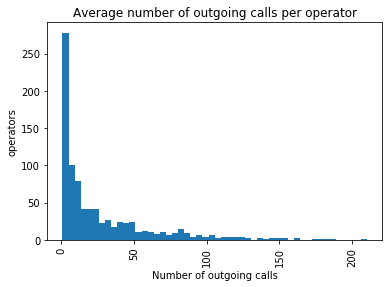

In [117]:
plt.hist(least_outgoing, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('Number of outgoing calls')
plt.ylabel('operators')
plt.title('Average number of outgoing calls per operator')
plt.show()

In [122]:
Array_ids = [953462.0, 937872.0, 958458.0, 932246.0, 919482.0, 919476.0, 891976.0, 919418.0, 914272.0, 914626.0, 899082, 0923526.0, 893804.0, 880028.0, 905538.0, 899250.0, 915556.0,  921818.0, 925104.0, 901884.0, 922710.0, 921592.0, 921574.0, 920414.0, 919504.0, 919482.0, 919418.0, 919376.0, 919370.0, 958458.0 ]

In [131]:
telecom_dataset.drop(telecom_dataset[telecom_dataset['operator_id'].isin(Array_ids)].index, inplace=True) 

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We can see that the majority of operators actually don't have many outgoing calls. This situation is similar to the one we saw before with missing calls and waiting time. And the outliers are already removed. This means, we need to be careful removing unprofitable operators not to remove too much.

Above I found 10 operators that have longest waiting time, most missing calls and least outgoing calls. 
These are the ones I would identify as least profitable, since the hypothesis test did not help me. 

General conclusion:
Since the hypothesis test did not help me make a decision, I tried to make my own method of choosing the worst performing operators.
